<a href="https://colab.research.google.com/github/eduardoprospero/IC/blob/main/IC_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Seleção

In [ ]:
#Seleção do arquivo

#nome = "Instance1.txt"
#nome = "Instance2.txt"
#nome = "Instance3.txt"
#nome = "Instance4.txt"
#nome = "Instance5.txt"
#nome = "Instance6.txt"
#nome = "Instance7.txt"
#nome = "Instance8.txt"
#nome = "Instance9.txt"
nome = "Instance10.txt"
#nome = "Instance11.txt"
#nome = "Instance12.txt"
#nome = "Instance13.txt"
#nome = "Instance14.txt"
#nome = "Instance15.txt"
#nome = "Instance16.txt"
#nome = "Instance17.txt"
#nome = "Instance18.txt"
#nome = "Instance19.txt"
#nome = "Instance20.txt"
#nome = "Instance21.txt"
#nome = "Instance22.txt"
#nome = "Instance23.txt"
#nome = "Instance24.txt"

#Leitura dos dados

In [ ]:
from inrc2_txt import read_inrc2_txt
from inrc2_json import read_inrc2_json
from inrc2_xml import read_inrc2_xml
#from outros_ros import processaRos, processaRos_ortec, processaRos_gpost, processaRos_whpp, processaRos_valouxis
from inrc1 import read_inrc1
from vq import read_vq

def didntCollectWell(nome_modelo):

	if(nome_modelo.upper() == "KEREM-IPVN"):
		return 0, {}, {}
	else:
		print("Inacessível")

def sul(origem_dados, nome_modelo, caminhos, especificacao = "NaoHa"):

	valido = True

	if(origem_dados.upper() == "INRC2"):
		print("Origem dos dados: INRC2")
	elif(origem_dados.upper() == "OUTROS"):
		print("Origem dos dados: OUTROS ("+especificacao+")")
	elif(origem_dados.upper() == "INRC1"):
		print("Origem dos dados: INRC1")
	elif(origem_dados.upper() == "VQ"):
		print("Origem dos dados: VQ")
	else:
		print("Erro! Origem dos dados desconhecida")
		valido = False
		
	if(nome_modelo.upper() == "KEREM-IPVN"): #a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems
		print("Modelo: a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems")
	else:
		print("Erro! Modelo utilizado desconhecido")
		valido = False
	
	if(not valido):
		if(nome_modelo.upper() == "KEREM-IPVN"):
			return 0, {}, {} #erro, nenhum set, nenhum parâmetro
		print("Nada será retornado!")
		
	else:
				
		if(origem_dados.upper() == "INRC2"):
			
			c_coleta = 1
			
			if(caminhos[0].upper() == "TXT"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_txt(caminhos[1], caminhos[2], caminhos[3])
			elif(caminhos[0].upper() == "JSON"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_json(caminhos[1], caminhos[2], caminhos[3])
			elif(caminhos[0].upper() == "XML"):
				c_coleta, arquivo_cenario, arquivos_semana, arquivo_historico = read_inrc2_xml(caminhos[1], caminhos[2], caminhos[3])
			else:
				print("Erro! Formato de arquivo desconhecido")
				c_coleta = 0
				
			if(not c_coleta):
				
				didntCollectWell(nome_modelo)
				
			else:			
				return createFrom_inrc2_TO_kerem_ipvn(arquivo_cenario, arquivos_semana, arquivo_historico)
				
		elif(origem_dados.upper() == "OUTROS"):
			c, r, a = processaRos(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
			
				if(especificacao.upper() == "ORTEC"):
					tudo = processaRos_ortec(r, a)
					
				elif(especificacao.upper() == "GPOST"):
					tudo = processaRos_gpost(r, a)
					
				elif(especificacao.upper() == "WHPP"):
					tudo = processaRos_whpp(r, a)
					
				elif(especificacao.upper() == "VALOUXIS"):
					tudo = processaRos_valouxis(r, a)
					
				return createFrom_outros_TO_kerem_ipvn(tudo)
				
		elif(origem_dados.upper() == "INRC1"):
			c, a, historico = read_inrc1(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
				return createFrom_inrc1_TO_kerem_ipvn(a, historico)
				
		elif(origem_dados.upper() == "VQ"):
			c, a = read_vq(caminhos)
			
			if(not c):
			
				didntCollectWell(nome_modelo)
				
			else:
				return createFrom_vq_TO_kerem_ipvn(a)
					
		else:
			print("Inacessível")

def createFrom_inrc2_TO_kerem_ipvn(arquivo_cenario, arquivos_semana, arquivo_historico):

	conjuntos = {}
	parametros = {}
	
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(7*arquivo_cenario["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arquivo_cenario["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arquivo_cenario["nurses"]:
		conjuntos["I"].append(nurse)
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arquivo_cenario["turnos"]:
		conjuntos["T"].append(turno)
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arquivo_cenario["forbidden"]
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = []
	for nurse in conjuntos["I"]:
		conjuntos["N_i"].append([])
	for i in range(len(arquivos_semana)):
		for j in range(len(conjuntos["I"])):
			for k in range(7):
				conta = 0
				for l in range(len(conjuntos["T"])):
					conta += arquivos_semana[i]["shiftsOffRequirement"][j][l][k]
				if(conta == len(conjuntos["T"])):
					conjuntos["N_i"][j].append(7*i+k)
	'''
	duração do turno t \in T em minutos
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["l_t"] = []
	for turno in conjuntos["T"]:
		parametros["l_t"].append(1)
	'''
	quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
		terá valor igual a dias por não ser expresso nos arquivos de dados
	'''
	parametros["m_max"] = []
	for nurse in conjuntos["I"]:
		parametros["m_max"].append([])
		for turno in conjuntos["T"]:
			parametros["m_max"][-1].append(len(conjuntos["D"]))
	'''
	quantidade mínima de minutos que a enfermeira i \in I deve trabalhar no horizonte
		terá valor de alocações mínima que a enfermeira deve ter por não ser expresso nos arquivos de dados
	'''
	parametros["b_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["b_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["b_min"][-1] = arquivo_cenario["assignments"][j][0]
	'''
	quantidade máxima de minutos que a enfermeira i \in I deve trabalhar no horizonte
		terá valor de alocações máxima que a enfermeira deve ter por não ser expresso nos arquivos de dados
	'''
	parametros["b_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["b_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["b_max"][-1] = arquivo_cenario["assignments"][j][1]
	#quantidade mínima de turnos seguidos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["c_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["c_min"][-1] = arquivo_cenario["consecutivoContratos"][j][0]
	#quantidade máxima de turnos seguidos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["c_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["c_max"][-1] = arquivo_cenario["consecutivoContratos"][j][1]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = []
	for i in range(len(conjuntos["I"])):
		parametros["o_min"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["o_min"][-1] = arquivo_cenario["consecutivaFolgaContratos"][j][0]
	#número máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = []
	for i in range(len(conjuntos["I"])):
		parametros["a_max"].append(0)
		for j in range(len(arquivo_cenario["contratos"])):
			if(arquivo_cenario["nursesContratos"][i][j]):
				parametros["a_max"][-1] = arquivo_cenario["limiteFinsSemanaTrabalhados"][j]
	
	'''
	penalidade por não alocar certa enfermeira em dado turno de dado dia
		terá valor 0 por não ser expresso nos arquivos de dados
	'''
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	'''
	penalidade por alocar certa enfermeira em dado turno de dado dia
		terá valor 1 quando necessário por não serem dados pesos distintos nos arquivos de dados
	'''
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	for i in range(len(arquivos_semana)):
		for j in range(len(conjuntos["I"])):
			for k in range(len(conjuntos["T"])):
				for l in range(7):
					parametros["p"][j][7*i+l][k] = arquivos_semana[i]["shiftsOffRequirement"][j][k][l]
	'''
	demanda do dia
		será a soma da quantidade de enfermeiras de cada habilidade (valor ótimo, o valor mínimo será "descartado")
	'''
	parametros["u"] = []
	for dia in conjuntos["D"]:
		parametros["u"].append([])
		for turno in conjuntos["T"]:
			parametros["u"][-1].append(0)
	for i in range(len(arquivos_semana)):
		for j in range(7):
			for k in range(len(conjuntos["T"])):
				for l in range(arquivo_cenario["quantidadeHabilidades"]):
					parametros["u"][7*i+j][k] += arquivos_semana[i]["demanda"][k][l][j][1]
	'''
	penalidade por alocar menos que a quantidade desejada de enfermeiras para certo turno de certo dia
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["w_min"] = []
	for dia in conjuntos["D"]:
		parametros["w_min"].append([])
		for turno in conjuntos["T"]:
			parametros["w_min"][-1].append(1)
	'''
	penalidade por alocar mais que a quantidade desejada de enfermeiras para certo turno de certo dia
		terá valor 1 por não ser expresso nos arquivos de dados
	'''
	parametros["w_max"] = []
	for dia in conjuntos["D"]:
		parametros["w_max"].append([])
		for turno in conjuntos["T"]:
			parametros["w_max"][-1].append(1)

	return 1, conjuntos, parametros, False
	
def createFrom_outros_TO_kerem_ipvn(arq):
	
	conjuntos = {}
	parametros = {}
	
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(7*arq["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arq["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arq["nurses"]:
		conjuntos["I"].append(nurse["nome"])
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arq["turnos"]:
		conjuntos["T"].append(turno["nome"])
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["forbidden"]
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = []
	for nurse in conjuntos["I"]:
		conjuntos["N_i"].append([])
	aux = []
	for nurse in conjuntos["I"]:
		aux.append([])
		for dia in conjuntos["D"]:
			aux[-1].append([])
			for turno in conjuntos["T"]:
				aux[-1][-1].append(0)
	for escolha in arq["shiftsOffRequirement"]:
		aux[escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = 1
	for i in range(len(conjuntos["I"])):
		for j in range(len(conjuntos["D"])):
			conta = 0
			for k in range(len(conjuntos["T"])):
				conta += aux[i][j][k]
			if(conta == len(conjuntos["T"])):
				conjuntos["N_i"][i].append(j)
	#duração do turno t \in T em minutos
	parametros["l_t"] = []
	for turno in arq["turnos"]:
		parametros["l_t"].append(turno["duracao"])
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de minutos que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = arq["b_min"]
	#quantidade máxima de minutos que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = arq["b_max"]
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = arq["c_min"]
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = arq["c_max"]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = arq["o_min"]
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = arq["a_max"]
	
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	for escolha in arq["shiftsOnRequirement"]:
		parametros["q"][escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = escolha["peso"]
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	for escolha in arq["shiftsOffRequirement"]:
		parametros["p"][escolha["nurse"]][escolha["posicao"]][escolha["turno"]] = escolha["peso"]
	parametros["u"] = []
	for i in range(len(conjuntos["W"])):
		for dia in arq["demanda"]:
			parametros["u"].append(dia)
	parametros["w_min"] = []
	for dia in conjuntos["D"]:
		parametros["w_min"].append([])
		for turno in conjuntos["T"]:
			parametros["w_min"][-1].append(arq["coverWeights"][0])
	parametros["w_max"] = []
	for dia in conjuntos["D"]:
		parametros["w_max"].append([])
		for turno in conjuntos["T"]:
			parametros["w_max"][-1].append(arq["coverWeights"][1])
	return 1, conjuntos, parametros, False

def createFrom_inrc1_TO_kerem_ipvn(arq, historico):

	conjuntos = {}
	parametros = {}
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(arq["quantidadeDias"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(arq["horizonte"]):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = []
	for nurse in arq["nurses"]:
		conjuntos["I"].append(nurse["ID"])
	#cunjunto de turnos
	conjuntos["T"] = []
	for turno in arq["turnos"]:
		conjuntos["T"].append(turno["ID"])
		
	
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["forbidden"]
	
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = arq["dontWork"]
	
	#duração do turno t \in T em minutos
	parametros["l_t"] = []
	for turno in arq["turnos"]:
		parametros["l_t"].append(int(turno["duracao"]))
		
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = justFill(len(conjuntos["I"]), 0)
	#quantidade máxima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = justFill(len(conjuntos["I"]), arq["quantidadeDias"]*24*60*60)
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = justFill(len(conjuntos["I"]), 1)
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = justFill(len(conjuntos["I"]), arq["quantidadeDias"])
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = justFill(len(conjuntos["I"]), 1)
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = justFill(len(conjuntos["I"]), arq["horizonte"])
	
	parametros["q"] = []
	for nurse in conjuntos["I"]:
		parametros["q"].append([])
		for dia in conjuntos["D"]:
			parametros["q"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["q"][-1][-1].append(0)
	parametros["p"] = []
	for nurse in conjuntos["I"]:
		parametros["p"].append([])
		for dia in conjuntos["D"]:
			parametros["p"][-1].append([])
			for turno in conjuntos["T"]:
				parametros["p"][-1][-1].append(0)
	parametros["u"] = arq["demanda"]
	parametros["w_min"] = arq["coverWeights"]
	parametros["w_max"] = arq["coverWeights"]
	
	return 1, conjuntos, parametros, historico

def createFrom_vq_TO_kerem_ipvn(arq):

	conjuntos = {}
	parametros = {}
	#cunjunto de dias
	conjuntos["D"] = []
	for i in range(arq["horizonte"]):
		conjuntos["D"].append(i)
	#cunjunto de semanas
	conjuntos["W"] = []
	for i in range(int(arq["horizonte"] / 7)):
		conjuntos["W"].append(i)
	#cunjunto de enfermeiras
	conjuntos["I"] = arq["nurses"]
	#cunjunto de turnos
	conjuntos["T"] = arq["shifts"]
		
	
	#cunjunto de sequências proibidas de turnos
	conjuntos["R_t"] = arq["r_t"]
	
	#conjunto de dias que a enfermeira i \in I não pode ser alocada
	conjuntos["N_i"] = arq["n_i"]
	
	#duração do turno t \in T em minutos
	parametros["l_t"] = arq["duracoes"]
		
	#quantidade máxima de turnos do tipo t \in T que a enfermeira i \in I pode ser alocada
	parametros["m_max"] = arq["m_max"]
	
	#quantidade mínima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_min"] = arq["b_min"]
	#quantidade máxima de SEGUNDOS que a enfermeira i \in I deve trabalhar no horizonte
	parametros["b_max"] = arq["b_max"]
	#quantidade mínima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_min"] = arq["c_min"]
	#quantidade máxima de turnos consecutivos que a enfermeira i \in I deve trabalhar
	parametros["c_max"] = arq["c_max"]
	#quantidade mínima de dias consecutivos de folga que a enfermeira i \in I pode ter
	parametros["o_min"] = arq["o_min"]
	#númerio máximo de fins de semana que a enfermeira i \in I pode trabalhar
	parametros["a_max"] = arq["a_max"]
	
	parametros["q"] = arq["q"]
	parametros["p"] = arq["p"]
	parametros["u"] = arq["demanda"]
	parametros["w_min"] = arq["w_min"]
	parametros["w_max"] = arq["w_max"]
	
	return 1, conjuntos, parametros, False

def justFill(size, value):
	retorno = []
	for i in range(size):
		retorno.append(value)
	return retorno

###a = sul("INRC1", "KEREM-IPVN", "INRC1-DS1/Hospital1-Emergency-Absence.xml")

#a1, b1, c1 = sul("INRC2","KEREM-IPVN", ["JSON", "json_n030w4/Sc-n030w4.json", ["json_n030w4/WD-n030w4-0.json","json_n030w4/WD-n030w4-1.json","json_n030w4/WD-n030w4-2.json","json_n030w4/WD-n030w4-3.json"], "json_n030w4/H0-n030w4-0.json"])
#sul("INRC2","KEREM-IPVN", ["TXT", "txt_n005w4/Sc-n005w4.txt", ["txt_n005w4/WD-n005w4-0.txt","txt_n005w4/WD-n005w4-1.txt","txt_n005w4/WD-n005w4-2.txt","txt_n005w4/WD-n005w4-3.txt"],"txt_n005w4/H0-n005w4-0.txt"])
#sul("INRC2","KEREM-IPVN", ["XML", "xml_n005w4/Sc-n005w4.xml", ["xml_n005w4/WD-n005w4-0.xml","xml_n005w4/WD-n005w4-1.xml","xml_n005w4/WD-n005w4-2.xml","xml_n005w4/WD-n005w4-3.xml"],"xml_n005w4/H0-n005w4-0.xml"])
#d1, e1, f1 = sul("OUTROS", "KEREM-IPVN", "ORTEC01.ros", "ORTEC")
#d2, e2, f2 = sul("OUTROS", "KEREM-IPVN", "GPost.ros", "GPOST")
#d3, e3, f3 = sul("OUTROS", "KEREM-IPVN", "Valouxis-1.ros", "VALOUXIS")
#d4, e4, f4 = sul("OUTROS", "KEREM-IPVN", "WHPP.ros", "WHPP")

a = sul("VQ", "KEREM-IPVN", nome)
a

Origem dos dados: VQ
Modelo: a hybrid Integer Programming and Variable Neighbourhood search algorithm to solve nurse rosteing problems


(1,
 {'D': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27],
  'I': ['A',
   'B',
   'C',
   'D',
   'E',
   'F',
   'G',
   'H',
   'I',
   'J',
   'K',
   'L',
   'M',
   'N',
   'O',
   'P',
   'Q',
   'R',
   'S',
   'T',
   'U',
   'V',
   'W',
   'X',
   'Y',
   'Z',
   'AA',
   'AB',
   'AC',
   'AD',
   'AE',
   'AF',
   'AG',
   'AH',
   'AI',
   'AJ',
   'AK',
   'AL',
   'AM',
   'AN'],
  'N_i': [[3, 7],
   [14, 15],
   [23, 24],
   [11, 12],
   [12, 13],
   [2, 3],
   [1, 11],
   [10, 11],
   [7, 22],
   [22, 27],
   [3, 21],
   [7, 8],
   [3, 4],
   [22, 23],
   [5, 8],
   [1, 2],
   [21, 24],
   [4, 5],
   [3, 11],
   [8, 9],
   [2, 14],
   [12, 19],
   [11, 26],
   [23, 27],
   [16, 22],
   [1, 12],
   [20, 21],
   [25, 26],
   [13, 27],
   [0, 23],
   [14, 15],
   [6, 7],
   [5, 8],
   [8, 9],
   [26, 27],
   [14, 15],
   [2, 18],
   [3,

#Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
#Criação do dataframe
enfermeiros = a[1]['I']
prob_sem1 = [2/7,3/7,5/7,4/7,1/7,5/7,3/7,4/7,3/7,5/7,0/7,5/7,3/7,5/7,5/7,3/7,3/7,3/7,5/7,4/7,2/7,4/7,5/7,5/7,4/7,4/7,5/7,4/7,5/7,4/7,4/7,3/7,5/7,4/7,3/7,1/7,2/7,3/7,2/7,5/7]
prob_sem2 = [4/7,5/7,1/7,2/7,5/7,4/7,4/7,5/7,4/7,5/7,5/7,3/7,5/7,2/7,4/7,4/7,5/7,4/7,2/7,3/7,5/7,3/7,2/7,5/7,5/7,2/7,5/7,3/7,2/7,4/7,3/7,4/7,4/7,4/7,5/7,5/7,5/7,4/7,5/7,4/7]
prob_sem3 = [5/7,3/7,5/7,4/7,5/7,3/7,5/7,3/7,5/7,3/7,5/7,4/7,4/7,5/7,3/7,5/7,2/7,5/7,5/7,5/7,5/7,5/7,5/7,3/7,5/7,5/7,3/7,5/7,5/7,5/7,5/7,4/7,5/7,5/7,5/7,4/7,5/7,5/7,3/7,3/7]
prob_sem4 = [5/7,5/7,5/7,5/7,5/7,4/7,3/7,5/7,5/7,3/7,5/7,3/7,3/7,4/7,5/7,5/7,4/7,3/7,5/7,5/7,5/7,5/7,3/7,2/7,4/7,5/7,5/7,3/7,3/7,5/7,5/7,3/7,3/7,3/7,2/7,5/7,5/7,3/7,5/7,5/7]

probs = [prob_sem1, prob_sem2, prob_sem3, prob_sem4]
labels = ['sem1', 'sem2', 'sem3', 'sem4']

df = pd.DataFrame({'sem1': prob_sem1, 'sem2': prob_sem2, 'sem3': prob_sem3, 'sem4': prob_sem4}, index = enfermeiros)
df.to_csv("semanalist.csv")
df

,sem1,sem2,sem3,sem4
A,0.285714,0.571429,0.714286,0.714286
B,0.428571,0.714286,0.428571,0.714286
C,0.714286,0.142857,0.714286,0.714286
D,0.571429,0.285714,0.571429,0.714286
E,0.142857,0.714286,0.714286,0.714286
F,0.714286,0.571429,0.428571,0.571429
G,0.428571,0.571429,0.714286,0.428571
H,0.571429,0.714286,0.428571,0.714286
I,0.428571,0.571429,0.714286,0.714286
J,0.714286,0.714286,0.428571,0.428571


<function matplotlib.pyplot.show>

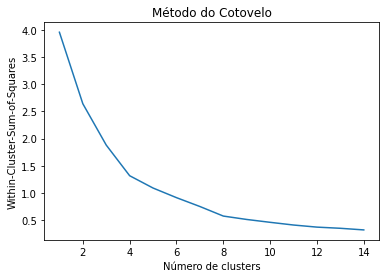

In [ ]:
#Escolha do valor de K pelo método do cotovelo

wcss = []
for i in range(1,15):
  kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10)
  kmeans.fit(df)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,15), wcss)
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters")
plt.ylabel("Within-Cluster-Sum-of-Squares")
plt.show

**K = 4**

In [ ]:
#Criando os clusters
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10)
clusters = kmeans.fit_predict(df)
clusters

array([2, 0, 1, 1, 2, 0, 3, 0, 2, 0, 2, 3, 3, 1, 0, 2, 0, 3, 1, 1, 2, 1,
       1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 2, 2, 3, 2, 0], dtype=int32)

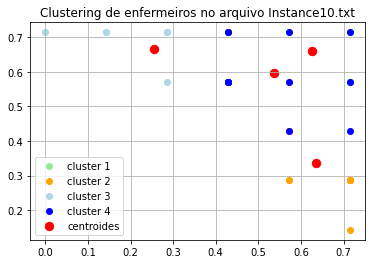

In [ ]:
#Plot do clustering
X = df.to_numpy()

plt.scatter(
    X[clusters == 0, 0], X[clusters == 0, 1],
    c='lightgreen',
    label='cluster 1'
)

plt.scatter(
    X[clusters == 1, 0], X[clusters == 1, 1],
    c='orange',
    label='cluster 2'
)

plt.scatter(
    X[clusters == 2, 0], X[clusters == 2, 1],
    c='lightblue',
    label='cluster 3'
)

plt.scatter(
    X[clusters == 3, 0], X[clusters == 3, 1],
    c='blue',
    label='cluster 4'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=70, marker='o',
    c='red',
    label='centroides'
)
plt.title('Clustering de enfermeiros no arquivo Instance10.txt')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Dataframe com os clusters
df['Cluster'] = clusters
df

,sem1,sem2,sem3,sem4,Cluster
A,0.285714,0.571429,0.714286,0.714286,2
B,0.428571,0.714286,0.428571,0.714286,3
C,0.714286,0.142857,0.714286,0.714286,1
D,0.571429,0.285714,0.571429,0.714286,1
E,0.142857,0.714286,0.714286,0.714286,2
F,0.714286,0.571429,0.428571,0.571429,3
G,0.428571,0.571429,0.714286,0.428571,0
H,0.571429,0.714286,0.428571,0.714286,3
I,0.428571,0.571429,0.714286,0.714286,2
J,0.714286,0.714286,0.428571,0.428571,3
